In [2]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")

In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///amar-shop.db")

print(db.dialect)
print(db.get_usable_table_names())

sqlite
['products', 'services']


In [4]:
db.run("SELECT * FROM products LIMIT 10;")

"[(1, 'Miniket Rice', 'MR001', 74.0, '2025-12-31', 'Aarong', 'Rice'), (2, 'Chinigura Rice', 'CR002', 115.0, '2025-11-30', 'Kazi Farms', 'Rice'), (3, 'Soyabean Oil', 'SO003', 177.0, '2026-06-15', 'Sundarban', 'Oil'), (4, 'White Sugar', 'WS004', 128.0, '2026-01-20', 'S. A. Group', 'Sugar'), (5, 'Red Lentil (Masoor Dal)', 'RL005', 119.0, '2025-09-10', 'PRAN', 'Lentil'), (6, 'Mustard Oil', 'MO006', 150.0, '2026-05-10', 'Rupchanda', 'Oil'), (7, 'Green Chili', 'GC007', 40.0, '2025-09-15', 'FreshMart', 'Vegetable'), (8, 'Potato', 'PT008', 30.0, '2025-12-20', 'FarmFresh', 'Vegetable'), (9, 'Onion', 'ON009', 50.0, '2025-11-25', 'DeshiOnion', 'Vegetable'), (10, 'Garlic', 'GL010', 60.0, '2025-10-30', 'PureSpice', 'Spice')]"

In [5]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)
agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=True)

In [6]:
# agent_executor.invoke(
#     "List the all vagetable type products"
# )

In [7]:
from typing_extensions import TypedDict, Annotated, TypedDict
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    query: str
    category: str
    sentiment: str
    response: str

In [8]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain_openai import ChatOpenAI
from langchain.tools import Tool

def sql_agent_tool(query: str):
    """
    Executes an SQL query using an AI-powered agent to fetch relevant information from the database.

    Args:
        state (State): A dictionary containing the user's query and related context.

    Returns:
        State: A dictionary containing the response from the database and the tool invocation details.
    """

    llm = ChatOpenAI(model="gpt-4o", temperature=0)
    agent_executor = create_sql_agent(llm, db=db, agent_type="openai-tools", verbose=True)
    response = agent_executor.invoke({"input": query})
    
    return response

In [9]:
def categorize(state: State) -> State:
    """Categorize the customer query into Technical, Billing, General, Products, or Services."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General, Products, Services, Recommendation. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}


def analyze_sentiment(state: State) -> State:
    """Analyze the sentiment of the customer query as Positive, Neutral, or Negative."""
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    """Provide a technical support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    """Provide a billing support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    """Provide a general support response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | ChatOpenAI(temperature=0)
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    """Escalate the query to a human agent due to negative sentiment."""
    return {"response": "This query has been escalated to a human agent due to its negative sentiment."}

In [10]:
from langchain.agents import initialize_agent, AgentType

def handle_products(state: State) -> State:
    """Use a LangChain agent to handle product-related queries with structured responses."""

    query = state["query"]

    sql_tool = Tool(
        name="Product_Database_Query",
        func=sql_agent_tool,
        description="Executes SQL queries to fetch product details."
    )

    # Initialize an agent that can use tools
    llm = ChatOpenAI(temperature=0)
    agent_executor = initialize_agent(
        tools=[sql_tool],
        llm=llm,
        agent=AgentType.OPENAI_FUNCTIONS,
        verbose=True
    )

    prompt = f"""
    You are a customer support agent handling product-related inquiries.
    Use the provided tool to fetch product information and respond in a structured manner.
    just show relevent informations. you dont need to show extra informations like product code etc.
    
    Query: {query}
    """
    
    response = agent_executor.run(prompt)
    
    return {"response": response}


from langchain.agents import initialize_agent, AgentType
from langchain.tools import Tool

def handle_services(state: State) -> State:
    """Use a LangChain agent to handle service-related queries with structured responses."""

    query = state["query"]

    sql_tool = Tool(
        name="service_database_query",
        func=sql_agent_tool,
        description="Executes SQL queries to fetch service details."
    )

    llm = ChatOpenAI(temperature=0)
    agent_executor = initialize_agent(
        tools=[sql_tool],
        llm=llm,
        agent=AgentType.OPENAI_FUNCTIONS,
        verbose=True
    )

    prompt = f"""
    You are a customer support agent specializing in Service-related inquiries.
    Use the provided tool to fetch service information and respond in a structured manner.
    
    Query: {query}
    """
    
    response = agent_executor.run(prompt)
    
    return {"response": response}

def handle_recommendation(state: State) -> State:
    """Use a LangChain agent to handle recommendation queries with structured responses for users."""

    query = state["query"].lower()

    sql_tool = Tool(
        name="recommendation_query",
        func=sql_agent_tool,
        description="Fetches recommended products/services for users from the database."
    )

    # Initialize an agent with the tool
    llm = ChatOpenAI(temperature=0)
    agent_executor = initialize_agent(
        tools=[sql_tool],
        llm=llm,
        agent=AgentType.OPENAI_FUNCTIONS,
        verbose=True
    )

    prompt = f"""
    You are a customer support agent specializing in recommending products and services to **users** (not shop owners).
    
    - Analyze the query and determine if the user is asking for **products**, **services**, or both.
    - If the user asks for multiple types, call the tool multiple times and provide information.
    - Suggest **appropriate quantities** for personal use (not bulk orders for businesses).
    - Ensure the response is structured clearly.

    Query: {query}
    """
    
    response = agent_executor.run(prompt)
    
    return {"response": response}


In [11]:
# from langgraph.prebuilt import ToolNode
# from langgraph.prebuilt import tools_condition

In [12]:
def route_query(state: State) -> str:
    """Route the query based on sentiment and category."""
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    elif state["category"] == "Products":
        return "handle_products"
    elif state["category"] == "Services":
        return "handle_services"
    elif state["category"] == "Recommendation":
        return "handle_recommendation"
    else:
        return "handle_general"

In [13]:
from langgraph.graph import StateGraph, END, START
workflow = StateGraph(State)

# Add nodes
# workflow.add_node(START, categorize)
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("handle_products", handle_products)
workflow.add_node("handle_services", handle_services)
workflow.add_node("escalate", escalate)
workflow.add_node("handle_recommendation", handle_recommendation)

In [14]:
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "handle_products": "handle_products",
        "handle_services": "handle_services",
        "handle_recommendation": "handle_recommendation",
        "escalate": "escalate"
    }

)

In [15]:
# workflow.add_conditional_edges("handle_products", tools_condition)
# workflow.add_conditional_edges("handle_services", tools_condition)

In [16]:
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("handle_products", END)
workflow.add_edge("handle_services", END)
workflow.add_edge("handle_recommendation", END)
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

In [17]:
app = workflow.compile()

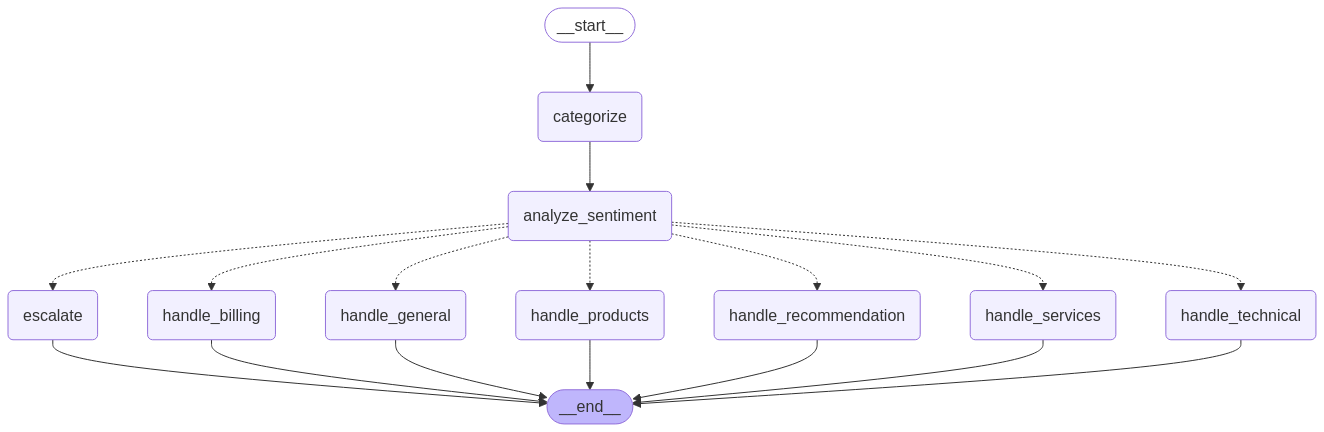

In [18]:
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        ),
    )
)


In [19]:
from typing import Dict

def run_customer_support(query: str) -> Dict[str, str]:
    """Process a customer query through the LangGraph workflow.
    
    Args:
        query (str): The customer's query
        
    Returns:
        Dict[str, str]: A dictionary containing the query's category, sentiment, and response
    """
    initial_state = {
        "messages": [{"role": "user", "content": query}],
        "query": query,
        "category": "", 
        "sentiment": "",
        "response": "" 
    }

    results = app.invoke(initial_state)

    return {
        "category": results.get("category", "Unknown"),
        "sentiment": results.get("sentiment", "Neutral"),
        "response": results.get("response", "I'm not sure how to answer that right now.")
    }


In [20]:

query = "My internet connection keeps dropping. Can you help?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: My internet connection keeps dropping. Can you help?
Category: Technical
Sentiment: Negative
Response: This query has been escalated to a human agent due to its negative sentiment.




In [21]:
query = "What are the Rice items do you have?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")



C:\Users\saraw\AppData\Local\Temp\ipykernel_9792\603726432.py:16: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 1.0. Use :meth:`~Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc.` instead.
  agent_executor = initialize_agent(
C:\Users\saraw\AppData\Local\Temp\ipykernel_9792\603726432.py:31: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = agent_executor.run(prompt)




> Entering new AgentExecutor chain...

Invoking: `Product_Database_Query` with `Rice`




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


0mproducts, services
Invoking: `sql_db_schema` with `{'table_names': 'products'}`



CREATE TABLE products (
	id INTEGER NOT NULL, 
	name VARCHAR NOT NULL, 
	product_code VARCHAR NOT NULL, 
	price FLOAT NOT NULL, 
	expiry_date DATE NOT NULL, 
	brand VARCHAR NOT NULL, 
	product_type VARCHAR NOT NULL, 
	PRIMARY KEY (id), 
	UNIQUE (product_code)
)

/*
3 rows from products table:
id	name	product_code	price	expiry_date	brand	product_type
1	Miniket Rice	MR001	74.0	2025-12-31	Aarong	Rice
2	Chinigura Rice	CR002	115.0	2025-11-30	Kazi Farms	Rice
3	Soyabean Oil	SO003	177.0	2026-06-15	Sundarban	Oil
The database contains a table named `products` with information about various products, including rice. Here are some details about rice products:

1. **Miniket Rice**
   - Product Code: MR001
   - Price: 74.0
   - Expiry Date:

In [22]:
query = "What are the services do you have?"
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")




> Entering new AgentExecutor chain...

Invoking: `Product_Database_Query` with `services`




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


0mproducts, services
Invoking: `sql_db_schema` with `{'table_names': 'services'}`



CREATE TABLE services (
	id INTEGER NOT NULL, 
	name VARCHAR NOT NULL, 
	service_code VARCHAR NOT NULL, 
	price FLOAT NOT NULL, 
	PRIMARY KEY (id), 
	UNIQUE (service_code)
)

/*
3 rows from services table:
id	name	service_code	price
1	Car Wash	CW001	20.0
2	House Cleaning	HC002	35.0
3	Lawn Mowing	LM003	40.0
The `services` table contains the following columns:

- `id`: A unique identifier for each service.
- `name`: The name of the service.
- `service_code`: A unique code for each service.
- `price`: The price of the service.

Here are some examples of services in the database:

1. Car Wash (Service Code: CW001) - $20.00
2. House Cleaning (Service Code: HC002) - $35.00
3. Lawn Mowing (Service Code: LM003) - $40.00

If you ha

In [23]:
query = "Suggest me some products within 1000 taka price."
result = run_customer_support(query)
print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")



> Entering new AgentExecutor chain...

Invoking: `Product_Database_Query` with `SELECT * FROM Products WHERE price <= 1000`




> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


0mproducts, services
Invoking: `sql_db_schema` with `{'table_names': 'products'}`



CREATE TABLE products (
	id INTEGER NOT NULL, 
	name VARCHAR NOT NULL, 
	product_code VARCHAR NOT NULL, 
	price FLOAT NOT NULL, 
	expiry_date DATE NOT NULL, 
	brand VARCHAR NOT NULL, 
	product_type VARCHAR NOT NULL, 
	PRIMARY KEY (id), 
	UNIQUE (product_code)
)

/*
3 rows from products table:
id	name	product_code	price	expiry_date	brand	product_type
1	Miniket Rice	MR001	74.0	2025-12-31	Aarong	Rice
2	Chinigura Rice	CR002	115.0	2025-11-30	Kazi Farms	Rice
3	Soyabean Oil	SO003	177.0	2026-06-15	Sundarban	Oil

Invoking: `sql_db_query_checker` with `{'query': 'SELECT name, price FROM products WHERE price <= 1000 LIMIT 10'}`


```sql
SELECT name, price FROM products WHERE price <= 1000 LIMIT 10

I